In [63]:
from matplotlib.image import imread
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff

In [64]:
#resize board image to (640, 640)
def resize_board_image(img_path):
    img = Image.open(img_path)
    img = img.resize((640, 640))
    img.save(img_path)
    return img_path

In [65]:
#turn grayscale; size 1D output
def grayscale(board):
    #grayscale value
    #RGB Value to grayscale formula (NTSC):
    #0.299 ∙ Red + 0.587 ∙ Green + 0.114 ∙ Blue
    board_gray = []
    for i in range(board.shape[0]):
        board_gray_row = []
        for j in range (board.shape[1]):
            r = board[i,j,0]
            g = board[i,j,1]
            b = board[i,j,2]
            board_gray_row.append(0.299*r + 0.587*g + 0.114*b)
        board_gray.append(board_gray_row)
    return np.array(board_gray)

In [66]:
#isolate each square on board
def get_squares(board):
    squares = []
    square_width = int(board.shape[0]/8)
    square_height = int(board.shape[1]/8)
    for i in range(8):
        squares_row = []
        for j in range (8):
            square = board[(square_height*i):(square_height*(i+1)), (square_width*j):(square_width*(j+1))]
            squares_row.append(square)
        squares.append(squares_row)
    return np.array(squares)

In [67]:
#crop out border
def crop(source, value):
    square = []
    for i in range(int(source.shape[0]*value), int(source.shape[0]*(1-value))):
        square_row = []
        for j in range (int(source.shape[0]*value), int(source.shape[0]*(1-value))):
            square_row.append(source[i][j])
        square.append(square_row)
    return np.array(square)

In [68]:
#save piece as tiff file
def save_img(square, save_path, tag, num):
    img = Image.fromarray(square)
    if num < 10:
        img.save(f"{save_path}/{tag}00{num}.tiff")
    elif num < 100:
        img.save(f"{save_path}/{tag}0{num}.tiff")
    else:
        img.save(f"{save_path}/{tag}{num}.tiff")

In [69]:
#save piece as txt file
def save_txt(square, save_path, tag, num):
    if num < 10:
        np.savetxt(f"{save_path}/{tag}00{num}.txt", square, delimiter =" ")
    elif num < 100:
        np.savetxt(f"{save_path}/{tag}0{num}.txt", square, delimiter =" ")
    else:
        np.savetxt(f"{save_path}/{tag}{num}.txt", square, delimiter =" ")

In [70]:
#get pieces from board
def get_board_pieces(path):
    #initialize number tags
    lb = 0
    db = 0
    lw = 0
    dw = 0
    
    for board_name in os.listdir(path):
        board_path = f"{path}/{board_name}"
        board = imread(resize_board_image(board_path))
        squares = get_squares(grayscale(board))
        #black pieces
        for i in range(8):
            if i%2==0: #even index -> light square
                lb += 1
#                 save_img(crop(squares[0,i],0.125), "light_squares/black_pieces", "lb", lb) #save img*
                save_txt(crop(squares[0,i],0.125), "light_squares_txt/black_pieces_txt", "lb", lb)
            else:
                db += 1
#                 save_img(crop(squares[0,i],0.125), "dark_squares/black_pieces", "db", db) #*
                save_txt(crop(squares[0,i],0.125), "dark_squares_txt/black_pieces_txt", "db", db)
        #get pawn for each square color
        db += 1
#         save_img(crop(squares[1,0],0.125), "dark_squares/black_pieces", "db", db) #*
        save_txt(crop(squares[1,0],0.125), "dark_squares_txt/black_pieces_txt", "db", db)
        lb += 1
#         save_img(crop(squares[1,1],0.125), "light_squares/black_pieces", "lb", lb) #*
        save_txt(crop(squares[1,1],0.125), "light_squares_txt/black_pieces_txt", "lb", lb)

        #white pieces
        for i in range(8):
            if i%2==0: #even index -> dark square
                dw += 1
#                 save_img(crop(squares[7,i],0.125), "dark_squares/white_pieces", "dw", dw) #*
                save_txt(crop(squares[7,i],0.125), "dark_squares_txt/white_pieces_txt", "dw", dw)
            else:
                lw += 1
#                 save_img(crop(squares[7,i],0.125), "light_squares/white_pieces", "lw", lw) #*
                save_txt(crop(squares[7,i],0.125), "light_squares_txt/white_pieces_txt", "lw", lw)
        #get pawn for each square color
        lw += 1
#         save_img(crop(squares[6,0],0.125), "light_squares/white_pieces", "lw", lw) #*
        save_txt(crop(squares[6,0],0.125), "light_squares_txt/white_pieces_txt", "lw", lw)
        dw += 1
#         save_img(crop(squares[6,1],0.125), "dark_squares/white_pieces", "dw", dw) #*
        save_txt(crop(squares[6,1],0.125), "dark_squares_txt/white_pieces_txt", "dw", dw)

In [71]:
def prewitt(square):
    square_height, square_width = square.shape
    #prewitt kernel
    h_filter = np.array([[-1, 0, 1], 
                        [-1, 0, 1], 
                        [-1, 0, 1]])
    v_filter = np.array([[-1, -1, -1], 
                        [ 0,  0,  0], 
                        [ 1,  1,  1]])

    #initialize gradient image
    gradient_image = np.zeros((square_height, square_width))

    for i in range(1, square_height - 1):
        for j in range(1, square_width - 1):
            h_value = (h_filter[0, 0] * square[i - 1, j - 1]) + \
                      (h_filter[0, 1] * square[i - 1, j]) + \
                      (h_filter[0, 2] * square[i - 1, j + 1]) + \
                      (h_filter[1, 0] * square[i, j - 1]) + \
                      (h_filter[1, 1] * square[i, j]) + \
                      (h_filter[1, 2] * square[i, j + 1]) + \
                      (h_filter[2, 0] * square[i + 1, j - 1]) + \
                      (h_filter[2, 1] * square[i + 1, j]) + \
                      (h_filter[2, 2] * square[i + 1, j + 1])

            v_value = (v_filter[0, 0] * square[i - 1, j - 1]) + \
                      (v_filter[0, 1] * square[i - 1, j]) + \
                      (v_filter[0, 2] * square[i - 1, j + 1]) + \
                      (v_filter[1, 0] * square[i, j - 1]) + \
                      (v_filter[1, 1] * square[i, j]) + \
                      (v_filter[1, 2] * square[i, j + 1]) + \
                      (v_filter[2, 0] * square[i + 1, j - 1]) + \
                      (v_filter[2, 1] * square[i + 1, j]) + \
                      (v_filter[2, 2] * square[i + 1, j + 1])
            #value per pixel in gradient image
            magnitude = np.sqrt(pow(h_value, 2) + pow(v_value, 2))
            gradient_image[i - 1, j - 1] = magnitude
    return gradient_image

In [72]:
#get feature vector
def feature_vector(array): #ndarray input
    return np.reshape(array, array.size)

In [73]:
#"distance" from avg_img
def euclidean_distance(v1, v2): #ndarray inputs
    if(v1.size != v2.size):
        print("Error")
    squared_differences = 0
    for i in range(v1.size):
        squared_differences += pow((v1[i] - v2[i]), 2)
    return np.sqrt(squared_differences)

In [74]:
#get distance of each sample
def get_distances(avg_img_fvector, folder_path):
    distances = []
    for image in os.listdir(folder_path):
#         img_fvector = feature_vector(tiff.imread(f"{folder_path}/{image}")) #for reading tiff
        img_fvector = feature_vector(np.loadtxt(f"{folder_path}/{image}")) #for reading txt
        distances.append(euclidean_distance(avg_img_fvector, img_fvector))
    return np.array(distances)

In [75]:
#create "average" image for each: db, dw, lb, lw
def get_avg_img():
    #dark_squares
    #db
    avg_img_db = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("dark_squares_txt/black_pieces_txt"):
#         array = tiff.imread(f"dark_squares/black_pieces/{image}") #for reading tiff
        array = np.loadtxt(f"dark_squares_txt/black_pieces_txt/{txt}") #for reading txt
        avg_img_db += array
        n += 1
    avg_img_db /= n
    #dw
    avg_img_dw = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("dark_squares_txt/white_pieces_txt"):
#         array = tiff.imread(f"dark_squares/white_pieces/{image}")
        array = np.loadtxt(f"dark_squares_txt/white_pieces_txt/{txt}")
        avg_img_dw += array
        n += 1
    avg_img_dw /= n

    #light_squares
    #lb
    avg_img_lb = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("light_squares_txt/black_pieces_txt"):
#         array = tiff.imread(f"light_squares/black_pieces/{image}")
        array = np.loadtxt(f"light_squares_txt/black_pieces_txt/{txt}")
        avg_img_lb += array
        n += 1
    avg_img_lb /= n
    #lw
    avg_img_lw = np.zeros((60, 60))
    n = 0
    for txt in os.listdir("light_squares_txt/white_pieces_txt"):
#         array = tiff.imread(f"light_squares/white_pieces/{image}")
        array = np.loadtxt(f"light_squares_txt/white_pieces_txt/{txt}")
        avg_img_lw += array
        n += 1
    avg_img_lw /= n
    
    return [avg_img_db, avg_img_dw, avg_img_lb, avg_img_lw]

In [16]:
#binary classifier
class SVM:

    def __init__(self, learning_rate=0.001, reg=0.01):
        self.weights = None
        self.bias = None
        self.learning_rate = learning_rate
        self.reg = reg
        
    def fit(self, X, y): #X & y as ndarrays
        n_samples, n_features = X.shape

        y_labels = np.where(y <= 0, -1, 1) #class labels

        # init weights
        self.weights = np.zeros(n_features) # can be randomized
        self.bias = 0

        for _ in range(1000): #no. of iterations can be changed
            for i, x_i in enumerate(X):
                if y_labels[i] * (np.dot(x_i, self.weights) - self.bias) >= 1:
                    self.weights -= self.learning_rate * (2 * self.reg * self.weights)
                else:
                    self.weights -= self.learning_rate * (2 * self.reg * self.weights - np.dot(x_i, y_labels[i]))
                    self.bias -= self.learning_rate * y_labels[i]


    def predict(self, X):
        approx = np.dot(X, self.weights) - self.bias
        return np.sign(approx)

In [17]:
#draw plot: training data, support vectors, decision boundary
def visualize_svm(svm, X, y):
    def get_hyperplane_value(x, weights, bias, offset):
        return (-weights[0] * x + bias + offset) / weights[1]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_facecolor("khaki")
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y, cmap="binary")
    plt.xlabel("Distance from Black Avg")
    plt.ylabel("Distance from White Avg")

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, svm.weights, svm.bias, 0)
    x1_2 = get_hyperplane_value(x0_2, svm.weights, svm.bias, 0)

    x1_1_m = get_hyperplane_value(x0_1, svm.weights, svm.bias, -1)
    x1_2_m = get_hyperplane_value(x0_2, svm.weights, svm.bias, -1)

    x1_1_p = get_hyperplane_value(x0_1, svm.weights, svm.bias, 1)
    x1_2_p = get_hyperplane_value(x0_2, svm.weights, svm.bias, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--") # decision boundary
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "w") # white sv 
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k") # black sv
    

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()

In [18]:
#compute accuracy
def accuracy(actual, predictions):
    accuracy = np.sum(actual == predictions) / len(actual)
    return accuracy

In [76]:
#run only when there are new boards
# get_board_pieces("boards")

In [77]:
avg_img_db, avg_img_dw, avg_img_lb, avg_img_lw = get_avg_img()

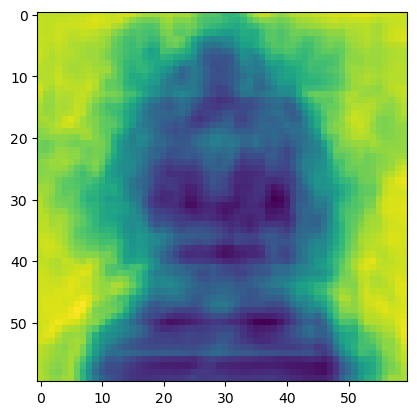

In [78]:
plt.imshow(avg_img_db)

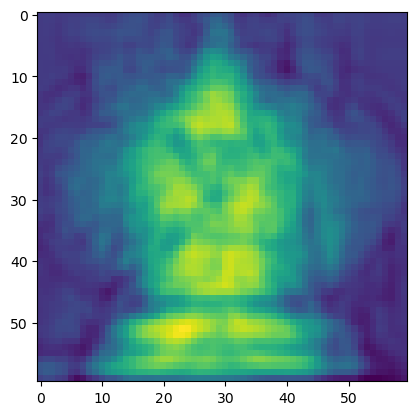

In [79]:
plt.imshow(avg_img_dw)

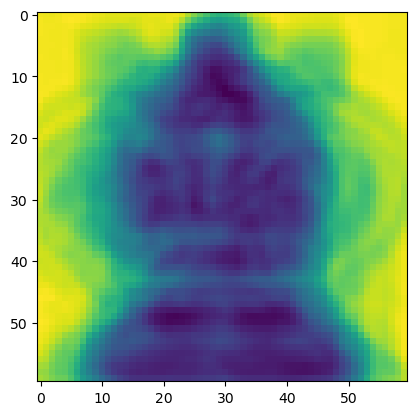

In [20]:
plt.imshow(avg_img_lb)

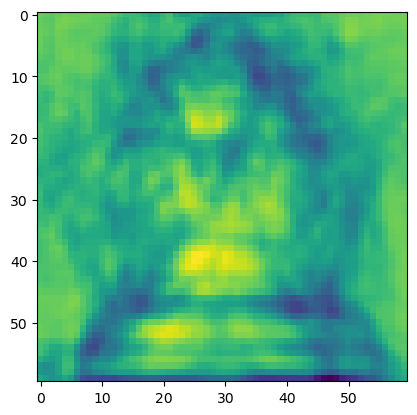

In [81]:
plt.imshow(avg_img_lw)

In [82]:
#get distances of each piece to the average

#for tiff files
# db_distances = get_distances(feature_vector(avg_img_db), "dark_squares/black_pieces")
# dw_distances = get_distances(feature_vector(avg_img_dw), "dark_squares/white_pieces")
# lb_distances = get_distances(feature_vector(avg_img_lb), "light_squares/black_pieces")
# lw_distances = get_distances(feature_vector(avg_img_lw), "light_squares/white_pieces")

#for txt files
db_distances = get_distances(feature_vector(avg_img_db), "dark_squares_txt/black_pieces_txt")
dw_distances = get_distances(feature_vector(avg_img_dw), "dark_squares_txt/white_pieces_txt")
lb_distances = get_distances(feature_vector(avg_img_lb), "light_squares_txt/black_pieces_txt")
lw_distances = get_distances(feature_vector(avg_img_lw), "light_squares_txt/white_pieces_txt")

In [83]:
#x: distance to avg_img_db; y: distance to avg_img_dw

#for tiff files
#dark 
# d_b_to_b = get_distances(feature_vector(avg_img_db), "dark_squares/black_pieces")
# d_b_to_w = get_distances(feature_vector(avg_img_dw), "dark_squares/black_pieces")
# d_w_to_b = get_distances(feature_vector(avg_img_db), "dark_squares/white_pieces")
# d_w_to_w = get_distances(feature_vector(avg_img_dw), "dark_squares/white_pieces")
# db = np.array([(lambda i: np.array([d_b_to_b[i],d_b_to_w[i]]))(i) for i in range(d_b_to_b.size)])
# dw = np.array([(lambda i: np.array([d_w_to_b[i],d_w_to_w[i]]))(i) for i in range(d_w_to_b.size)])
# x_ds_train = np.concatenate((db,dw),axis=0)
# y_ds_train = np.append(np.ones(dw.shape[0]), (np.ones(db.shape[0])*-1)) #white: 1; black: -1

# # light
# l_b_to_b = get_distances(feature_vector(avg_img_lb), "light_squares/black_pieces")
# l_b_to_w = get_distances(feature_vector(avg_img_lw), "light_squares/black_pieces")
# l_w_to_b = get_distances(feature_vector(avg_img_lb), "light_squares/white_pieces")
# l_w_to_w = get_distances(feature_vector(avg_img_lw), "light_squares/white_pieces")
# lb = np.array([(lambda i: np.array([l_b_to_b[i],l_b_to_w[i]]))(i) for i in range(l_b_to_b.size)])
# lw = np.array([(lambda i: np.array([l_w_to_b[i],l_w_to_w[i]]))(i) for i in range(l_w_to_b.size)])
# x_ls_train = np.concatenate((lb,lw),axis=0)
# y_ls_train = np.append(np.ones(lw.shape[0]), (np.ones(lb.shape[0])*-1))


#for txt files
#dark 
d_b_to_b = get_distances(feature_vector(avg_img_db), "dark_squares_txt/black_pieces_txt")
d_b_to_w = get_distances(feature_vector(avg_img_dw), "dark_squares_txt/black_pieces_txt")
d_w_to_b = get_distances(feature_vector(avg_img_db), "dark_squares_txt/white_pieces_txt")
d_w_to_w = get_distances(feature_vector(avg_img_dw), "dark_squares_txt/white_pieces_txt")
db = np.array([(lambda i: np.array([d_b_to_b[i],d_b_to_w[i]]))(i) for i in range(d_b_to_b.size)])
dw = np.array([(lambda i: np.array([d_w_to_b[i],d_w_to_w[i]]))(i) for i in range(d_w_to_b.size)])
x_ds_train = np.concatenate((db,dw),axis=0)
y_ds_train = np.append(np.ones(dw.shape[0]), (np.ones(db.shape[0])*-1)) #white: 1; black: -1

# light
l_b_to_b = get_distances(feature_vector(avg_img_lb), "light_squares_txt/black_pieces_txt")
l_b_to_w = get_distances(feature_vector(avg_img_lw), "light_squares_txt/black_pieces_txt")
l_w_to_b = get_distances(feature_vector(avg_img_lb), "light_squares_txt/white_pieces_txt")
l_w_to_w = get_distances(feature_vector(avg_img_lw), "light_squares_txt/white_pieces_txt")
lb = np.array([(lambda i: np.array([l_b_to_b[i],l_b_to_w[i]]))(i) for i in range(l_b_to_b.size)])
lw = np.array([(lambda i: np.array([l_w_to_b[i],l_w_to_w[i]]))(i) for i in range(l_w_to_b.size)])
x_ls_train = np.concatenate((lb,lw),axis=0)
y_ls_train = np.append(np.ones(lw.shape[0]), (np.ones(lb.shape[0])*-1))

SVM classification accuracy 0.96


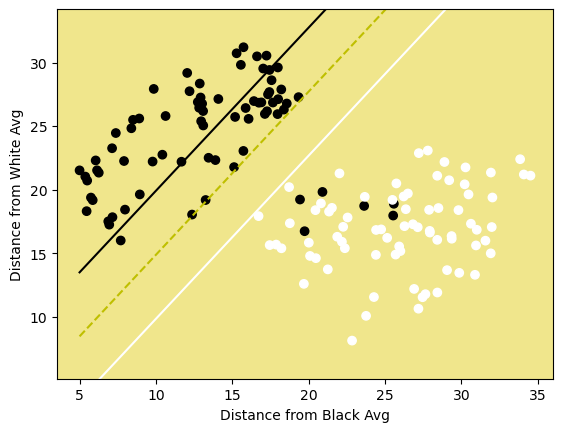

In [84]:
#TEST Training

#dark squares
d_svm = SVM()
d_svm.fit(x_ds_train, y_ds_train)
predictions = d_svm.predict(x_ds_train)
print("SVM classification accuracy", accuracy(y_ds_train, predictions))
visualize_svm(d_svm, x_ds_train, y_ds_train)

SVM classification accuracy 0.96


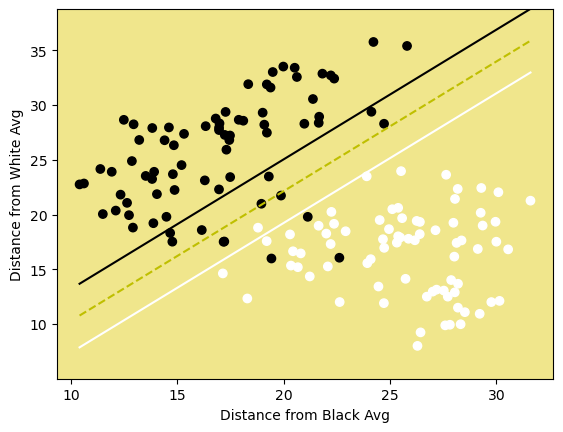

In [85]:
#light squares
l_svm = SVM()
l_svm.fit(x_ls_train, y_ls_train)
predictions = l_svm.predict(x_ls_train)
print("SVM classification accuracy", accuracy(y_ls_train, predictions))
visualize_svm(l_svm, x_ls_train, y_ls_train)

In [87]:
#get avg_prewitt
def get_avg_prewitt():
    def get_avg(db, dw, lb, lw):
        #position > 4 = skip
        avg = np.zeros((60, 60))
        n = 0
        #db
        if db > 4:
            pass
        else:
            for i,txt in enumerate(os.listdir(f"dark_squares_txt/black_pieces_txt")):
                if i%5 == db:
#                     array = prewitt(tiff.imread(f"dark_squares/black_pieces/{image}")) #for reading tiff
                    array = prewitt(np.loadtxt(f"dark_squares_txt/black_pieces_txt/{txt}")) #for reading txt
                    avg += array
                    n += 1
        #dw
        if dw > 4:
            pass
        else:
            for i,txt in enumerate(os.listdir(f"dark_squares_txt/white_pieces_txt")):
                if i%5 == dw:
#                     array = prewitt(tiff.imread(f"dark_squares/white_pieces/{image}"))
                    array = prewitt(np.loadtxt(f"dark_squares_txt/white_pieces_txt/{txt}"))
                    avg += array
                    n += 1
        #lb
        if lb > 4:
            pass
        else:
            for i,txt in enumerate(os.listdir(f"light_squares_txt/black_pieces_txt")):
                if i%5 == lb:
#                     array = prewitt(tiff.imread(f"light_squares/black_pieces/{image}"))
                    array = prewitt(np.loadtxt(f"light_squares_txt/black_pieces_txt/{txt}"))
                    avg += array
                    n += 1
        #lw
        if lw > 4:
            pass
        else:
            for i,txt in enumerate(os.listdir(f"light_squares_txt/white_pieces_txt")):
                if i%5 == lw:
#                     array = prewitt(tiff.imread(f"light_squares/white_pieces/{image}"))
                    array = prewitt(np.loadtxt(f"light_squares_txt/white_pieces_txt/{txt}"))
                    avg += array
                    n += 1
        avg /= n
        return avg
    
#     (db, dw, lb, lw) positions based on get_board_pieces()
#     p: n%5==4 all (4,4,4,4)
#     r: n%5==3 db, lw; n%5==0 dw, lb (3, 0, 0, 3)
#     n: n%5==0 db, lw; n%5==3 dw, lb (0, 3, 3, 0)
#     b: n%5==2 db, lw; n%5==1 dw, lb (2, 1, 1, 2)
#     k: n%5==1 dw; n%5==2 lb (5, 1, 2, 5)
#     q: n%5==1 db; n%5==2 lw (1, 5, 5, 2)

    avg_p_p = get_avg(4,4,4,4)
    avg_p_r = get_avg(3, 0, 0, 3)
    avg_p_n = get_avg(0, 3, 3, 0)
    avg_p_b = get_avg(2, 1, 1, 2)
    avg_p_k = get_avg(5, 2, 2, 5)
    avg_p_q = get_avg(1, 5, 5, 1)

    return [avg_p_p, avg_p_r, avg_p_n, avg_p_b, avg_p_k, avg_p_q]

In [88]:
avg_p_p, avg_p_r, avg_p_n, avg_p_b, avg_p_k, avg_p_q = get_avg_prewitt()

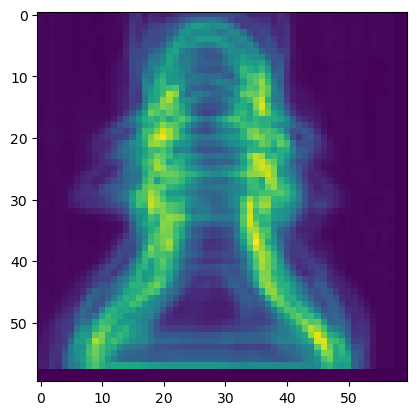

In [89]:
plt.imshow(avg_p_p)

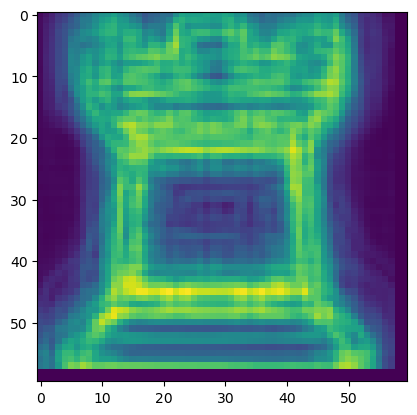

In [90]:
plt.imshow(avg_p_r)

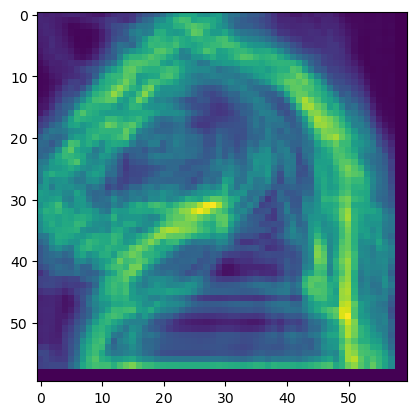

In [91]:
plt.imshow(avg_p_n)

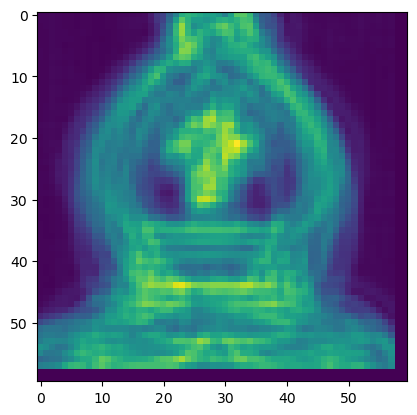

In [92]:
plt.imshow(avg_p_b)

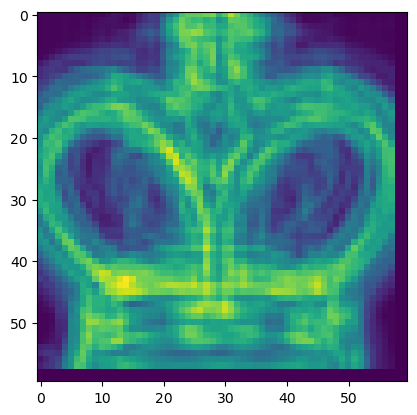

In [93]:
plt.imshow(avg_p_k)

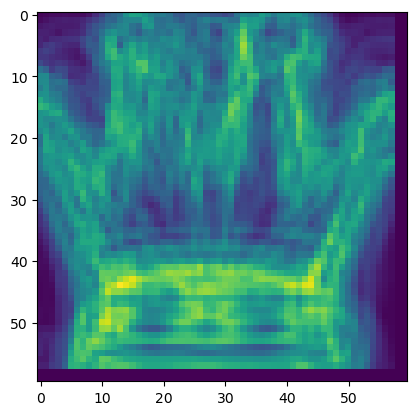

In [94]:
plt.imshow(avg_p_q)